# Continuous Control

---

This notebook presents the work of training a Reinforcement Learning (RL) agent to control 20 double-jointed arms to reach moving targets, in the Unity ML-Agents environment. The model that based on the Deep Deterministic Policy Gradient(DDPG) algorithm.

### Contents
1. [Start the environment](#1.-Start-the-Environment)
2. [Examine the State and Action Spaces](#2.-Examine-the-State-and-Action-Spaces)
3. [Take Random Actions in the Environment](#3.-Take-Random-Actions-in-the-Environment)
4. [Agent Architecture](#4.-Agent-Architecture)
4. [Train the Agent](#5.-Train-the-Agent)
6. [Discussion](#6.-Discussion)
7. [Future Improvements](#7.-Future-Improvements)


---
### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).


In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded, as instructed in the README.

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

---
### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the arm's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


---
### 3. Take Random Actions in the Environment

Just for fun, in the next code cell, let's see what the agent does before it's trained.

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for _ in range(100):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.009999999776482582


---
### 4. Agent Architecture

Different than the previous task where we've trained an agent to [collect bananas](https://github.com/jibin-liu/unity-ml-agent-banana-collector), the action space in this case is not discrete but continuous. There are many ways to work out the continuous action space, but here we're going to use the [DDPG](https://arxiv.org/abs/1509.02971) algorithm.

DDPG is an Actor-Critic style algorithm, in which there are two important components: actor and critic. Actor is a model that predict an action based on the given state, where critic is a q-value approximator that outputs the action value based on given state and action pair. The algorithm states as:

<img src="./img/ddpg_algorithm.png" width="600" />

The default hyperparameters are stored at [configuration.py](./configuration.py)

---
### 5. Train the Agent

Now let's use the defined model and configuration to train the model

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from ddpg_agent import Agent
from configuration import Configuration

In [7]:
def ddpg(agent, n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        local_scores = np.zeros(num_agents)
        for _ in range(max_t):
            # pick actions
            actions = agent.act(states)
            
            # take actions and observe the environments
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # update the agent
            agent.step(states, actions, rewards, next_states, dones)
            
            # update states and book-keeping
            states = next_states
            local_scores += rewards
            if np.any(dones):
                break

        local_ave_score = np.mean(local_scores)
        scores_deque.append(local_ave_score)
        scores.append(local_ave_score)
        
        # real-time logging
        consecutive_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'.
              format(i_episode,
                     consecutive_score,
                     local_ave_score,
                     np.min(local_scores),
                     np.max(local_scores)),
              end="")
        
        # save the model every 100 episodes
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, consecutive_score))
        
        # check if problem is solved
        if consecutive_score >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.
                  format(i_episode, consecutive_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

/home/jibin/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 28.04	Score: 37.69	Min: 32.69	Max: 39.61
Episode 106	Average Score: 30.23	Score: 37.29	Min: 32.38	Max: 39.47
Environment solved in 106 episodes!	Average Score: 30.23


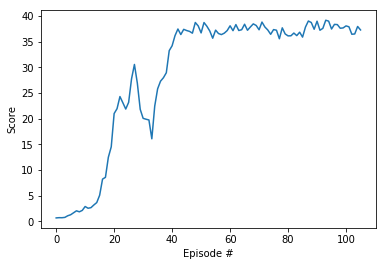

In [7]:
def train_ddpg():

    default_config = Configuration()
    agent = Agent(state_size=state_size, action_size=action_size, config=default_config)
    scores = ddpg(agent)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

train_ddpg()

---
### 6. Discussion

A lot of attempts have been tried before I solve this problem. Below I'm going to discuss the effects of some hyperparameters, as well as algorithm details.

#### 6.1 Batch normalization

Below it presents the agent where batch normalization is turned off. Comparing with the training with batch normalization, in this case the agent learns a bit faster and smoother. In the DDPG paper, it mentions that the batch normalization can help with learning low demension feature vector input. In my experiments, the effects of batch normalization also depends on other hyperparameters. So in general, it can help agent to learn better.

Episode 99	Average Score: 30.03	Score: 38.15	Min: 36.59	Max: 39.50
Environment solved in 99 episodes!	Average Score: 30.03


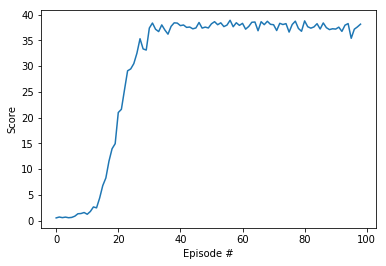

In [16]:
def no_batch_normalization():
    config = Configuration()
    config.batch_normalization_actor = False
    config.batch_normalization_critic = False
    agent = Agent(state_size=state_size, action_size=action_size, config=config)
    scores = ddpg(agent, n_episodes=300)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

no_batch_normalization()

#### 6.2 Learning rate

Below it presents the agent where has its critic's learning rate has been lowered from `1e-3` to `1e-4`. Here the learning rate seems to only affect the agent in the fact of learning speed, but not the performance (i.e., agent cannot learn).

Episode 100	Average Score: 25.25	Score: 37.85	Min: 34.95	Max: 39.54
Episode 113	Average Score: 30.05	Score: 37.60	Min: 34.70	Max: 39.15
Environment solved in 113 episodes!	Average Score: 30.05


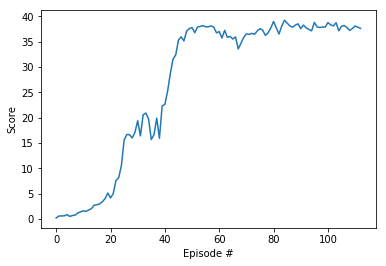

In [ ]:
def lower_learning_rate():
    config = Configuration()
    config.lr_critic = 1e-4
    agent = Agent(state_size=state_size, action_size=action_size, config=config)
    scores = ddpg(agent, n_episodes=300)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

lower_learning_rate()

#### 6.3 Noise random function

Below it presents the agent where the random function in noise process is changed from sampling of standard normal distribution to uniform distribution. The noise function is used here to balance the "exploration" and "exploitation". Adding the noise function to action space can help the agent to explore. Choosing the noise function, however, has to depend on specific problems to be solved. In this case, the uniform random function doesn't work well. Part of the reason could be that the random values are limit in the range of `[0-1)`. On the other hand, standard normal random function (i.e., the one used in the default configuration) helps the agent to learn much better.

/home/jibin/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 10.25	Score: 20.22	Min: 6.66	Max: 27.20
Episode 200	Average Score: 19.90	Score: 12.20	Min: 7.55	Max: 20.841
Episode 300	Average Score: 12.61	Score: 8.42	Min: 4.02	Max: 15.6643


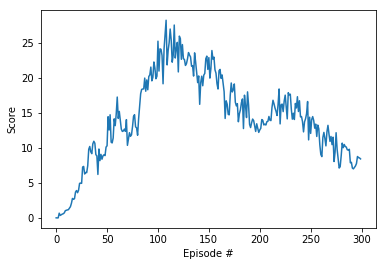

In [7]:
def uniform_random_noise():
    config = Configuration()
    config.noise_func = np.random.random_sample
    agent = Agent(state_size=state_size, action_size=action_size, config=config)
    scores = ddpg(agent, n_episodes=300)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

uniform_random_noise()

#### 6.4 Random seed

This is the factor that gave me most of the "troubles". Picking a random seed can be an issue, when the algorithm can be very unstable depends on the random seed. Here is one example of a random seed that doesn't "work" well.

Episode 100	Average Score: 1.68	Score: 5.57	Min: 2.63	Max: 18.56
Episode 200	Average Score: 9.53	Score: 11.30	Min: 5.76	Max: 16.150
Episode 300	Average Score: 11.70	Score: 10.76	Min: 6.65	Max: 13.619


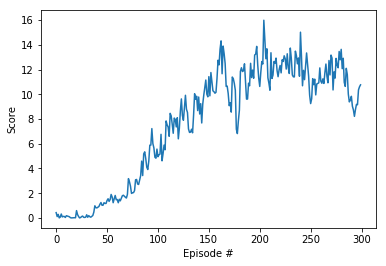

In [11]:
def random_seed():
    config = Configuration()
    config.random_seed = 111
    agent = Agent(state_size=state_size, action_size=action_size, config=config)
    scores = ddpg(agent, n_episodes=300)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

random_seed()

#### 6.5 L2 Weight Decay

In the DDPG paper, a weight decay is added onto the Critic. However in my experiments, this doesn't really work well for this problem. Here it presents an agent with L2 weight decay is set on critic, with value of 0.0001. The agent started well to learn something, but suddenly it stops learning. One reason could be that the weight decay was too large, that it arbitrarily set the weight to be zero for some nodes in the nerual network.

Episode 100	Average Score: 0.74	Score: 0.31	Min: 0.07	Max: 0.65
Episode 200	Average Score: 0.37	Score: 0.45	Min: 0.00	Max: 1.01
Episode 300	Average Score: 0.38	Score: 0.32	Min: 0.00	Max: 0.68


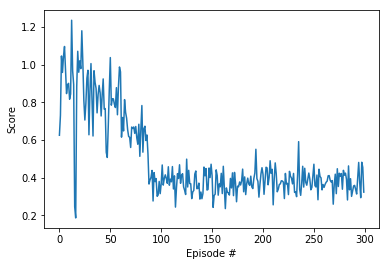

In [9]:
def l2_weight_decay():
    config = Configuration()
    config.l2_weight_decay = 0.0001
    agent = Agent(state_size=state_size, action_size=action_size, config=config)
    scores = ddpg(agent, n_episodes=300)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

l2_weight_decay()

#### 6.6 Underlying Neural Network

The following example presents an agent with different underlying neural network comparing the default one. The differentces are, in `model_2`:
- the actor network has only one hidden layer, whereas two hidden layers in default model
- the critic network has three hidden layers, whereas two hidden layers in default model
- the critic network uses `leaky_relu` as activation function, whereas in default model it uses `relu`.

There isn't much differences, however, in terms of agent learning speed and performance.

/home/jibin/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 27.07	Score: 35.77	Min: 31.40	Max: 39.11
Episode 109	Average Score: 30.30	Score: 38.07	Min: 36.02	Max: 39.58
Environment solved in 109 episodes!	Average Score: 30.30


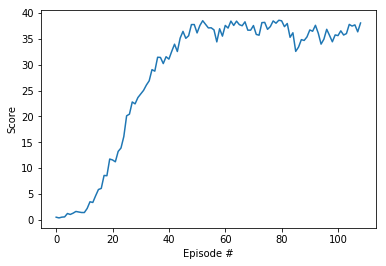

In [8]:
import model_2


def different_neural_network():
    config = Configuration()
    config.actor = model_2.Actor
    config.critic = model_2.Critic
    agent = Agent(state_size=state_size, action_size=action_size, config=config)
    scores = ddpg(agent, n_episodes=300)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

different_neural_network()

### 7. Future Improvements

There are a few places where this work can be improved:
-  There are many other algorithms that have been proved to increase the learning speed, such as Trust Region Policy Optimization (TRPO) and Truncated Natural Policy Gradient (TNPG).
- The batch size can be experimented as well to see if it can helps the agent to learn faster
- Use N-step boostraping or lambda bootstraping in critic network, that may help the agent to make better prediction of q values.